<a href="https://colab.research.google.com/github/Aaban-Saad/CSE445-Qurbani-Cow-Price-Prediction/blob/main/Cow_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("/content/sample_data/Cow_Price_Dataset_Extended.csv")
df = df.dropna()
df.head()

,Age,Teeth,Color,Gender,Weight,Horn,Breed,Location,Price
0,5,7,White and Red,Male,60.495033,Yes,Aus,Gazipur,31815.05469
1,1,2,Black and Brown,Male,77.287780,Yes,Deshi,Nilfamari,32670.61943
2,4,8,Cross,Male,56.999058,Yes,Holstein Cross,Mirpur,33131.58034
3,3,6,Red,Male,514.000000,No,Brahma,Naogaon,33557.00000
4,1,2,White,Male,86.546212,No,Pakri,Narayanganj,33789.06166


In [ ]:
# import pandas as pd
# import numpy as np

# def generate_synthetic_cow_data(original_df, num_records=1000, weight_noise_factor=0.1,
#                                 fixed_price_to_weight_ratio=500.0, price_noise_factor=0.2):
#     """
#     Generates synthetic cow data based on an existing DataFrame, maintaining
#     relationships between features and adding noise.

#     Args:
#         original_df (pd.DataFrame): The original DataFrame to base the synthetic data on.
#         num_records (int): The number of new synthetic records to generate.
#         weight_noise_factor (float): Factor to control the amount of noise added to weight.
#                                      (e.g., 0.1 means noise up to 10% of weight's std dev).
#         fixed_price_to_weight_ratio (float): The fixed ratio to use for Price / Weight.
#         price_noise_factor (float): Factor to control the amount of noise added directly to the price.
#                                     (e.g., 0.2 means noise up to 20% of the calculated price).

#     Returns:
#         pd.DataFrame: A new DataFrame containing the generated synthetic data.
#     """

#     # --- 1. Analyze existing relationships and distributions from original data ---

#     # Map Age to observed Teeth values to maintain their relationship
#     age_teeth_map = {}
#     for age in original_df['Age'].unique():
#         # Get unique Teeth values for each Age
#         teeth_for_age = original_df[original_df['Age'] == age]['Teeth'].unique()
#         if len(teeth_for_age) > 0:
#             age_teeth_map[age] = teeth_for_age.tolist()

#     # Get unique Age values for sampling
#     age_unique = original_df['Age'].unique()

#     # Get distributions of categorical features for sampling
#     # Using value_counts(normalize=True) to get proportions for weighted random choice
#     color_dist = original_df['Color'].value_counts(normalize=True)
#     gender_dist = original_df['Gender'].value_counts(normalize=True)
#     horn_dist = original_df['Horn'].value_counts(normalize=True)
#     breed_dist = original_df['Breed'].value_counts(normalize=True)
#     location_dist = original_df['Location'].value_counts(normalize=True)

#     # Get standard deviation of Weight for noise calculation
#     weight_std = original_df['Weight'].std()

#     # --- 2. Generate new data points ---
#     new_data = []

#     for _ in range(num_records):
#         # Sample Age from the unique ages in the original data
#         new_age = np.random.choice(age_unique)

#         # Sample Teeth based on the chosen Age to maintain relationship
#         # Fallback to all unique teeth if the specific age is not in the map (unlikely but safe)
#         new_teeth = np.random.choice(age_teeth_map.get(new_age, original_df['Teeth'].unique()))

#         # Sample other categorical features based on their original distributions
#         new_color = np.random.choice(color_dist.index, p=color_dist.values)
#         new_gender = np.random.choice(gender_dist.index, p=gender_dist.values)
#         new_horn = np.random.choice(horn_dist.index, p=horn_dist.values)
#         new_breed = np.random.choice(breed_dist.index, p=breed_dist.values)
#         new_location = np.random.choice(location_dist.index, p=location_dist.values)

#         # Generate Weight with noise
#         # Sample a base weight from the original distribution, then add Gaussian noise
#         sampled_weight_base = np.random.choice(original_df['Weight'].dropna().values)
#         new_weight = sampled_weight_base + np.random.normal(0, weight_std * weight_noise_factor)
#         new_weight = max(10.0, new_weight) # Ensure weight is positive and reasonable

#         # Calculate Price based on the fixed ratio and add noise
#         base_price = new_weight * fixed_price_to_weight_ratio
#         # Add noise proportional to the base price
#         new_price = base_price + np.random.normal(0, base_price * price_noise_factor)
#         new_price = max(1000.0, new_price) # Ensure price is positive and reasonable

#         new_data.append({
#             'Age': new_age,
#             'Teeth': new_teeth,
#             'Color': new_color,
#             'Gender': new_gender,
#             'Weight': new_weight,
#             'Horn': new_horn,
#             'Breed': new_breed,
#             'Location': new_location,
#             'Price': new_price
#         })

#     # Create a DataFrame from the generated data
#     synthetic_df = pd.DataFrame(new_data)
#     return synthetic_df

In [ ]:
# synthetic_data = generate_synthetic_cow_data(df, num_records=1000)

# # Save the synthetic data to a CSV file
# synthetic_data.to_csv("synthetic_cow_data.csv", index=False)

# print("Synthetic data saved to synthetic_cow_data.csv")

Number of rows: 1485


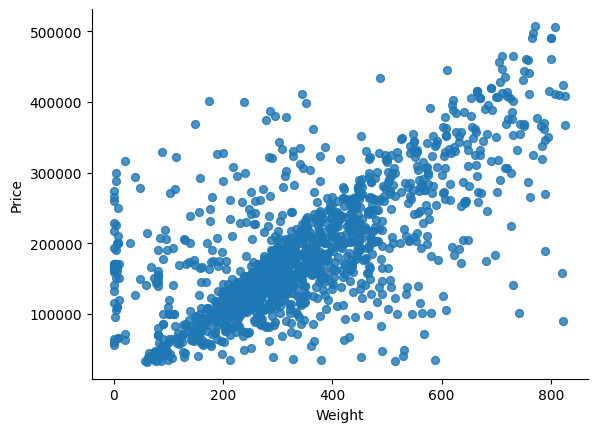

In [ ]:
# @title Weight vs Price
df.plot(kind='scatter', x='Weight', y='Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
print(f"Number of rows: {len(df)}")

In [ ]:
def mon_to_kg(weight):
  """Converts weight from mon to kg if less than 20, otherwise assumes kg."""
  try:
    weight_float = float(weight)
    if weight_float < 20:
      return weight_float * 37.3242
    else:
      return weight_float
  except ValueError:
    # If the weight is not a float and conversion fails, return None
    return None

df['Weight'] = df['Weight'].apply(mon_to_kg)

# Drop rows where the weight conversion resulted in None
df = df.dropna(subset=['Weight'])

In [ ]:
def remove_price_weight_ratio_outliers(df):
  """
  Removes rows from a DataFrame where the 'Price/Weight' ratio is an outlier
  using the IQR method.

  Args:
    df (pd.DataFrame): The input DataFrame, expected to have 'Price' and 'Weight' columns.

  Returns:
    pd.DataFrame: A new DataFrame with rows containing 'Price/Weight' ratio outliers removed.
  """
  # Ensure 'Weight' is not zero to avoid division by zero
  df_copy = df[df['Weight'] != 0].copy()
  df_copy['Price_Weight_Ratio'] = df_copy['Price'] / df_copy['Weight']

  Q1 = df_copy['Price_Weight_Ratio'].quantile(0.25)
  Q3 = df_copy['Price_Weight_Ratio'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_filtered = df_copy[(df_copy['Price_Weight_Ratio'] >= lower_bound) & \
                        (df_copy['Price_Weight_Ratio'] <= upper_bound)]

  # Optionally, you might want to drop the temporary 'Price_Weight_Ratio' column
  return df_filtered.drop(columns=['Price_Weight_Ratio'])

df= remove_price_weight_ratio_outliers(df)

In [ ]:
def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_filtered

df = remove_outliers_iqr(df, 'Weight')
df = remove_outliers_iqr(df, 'Price')

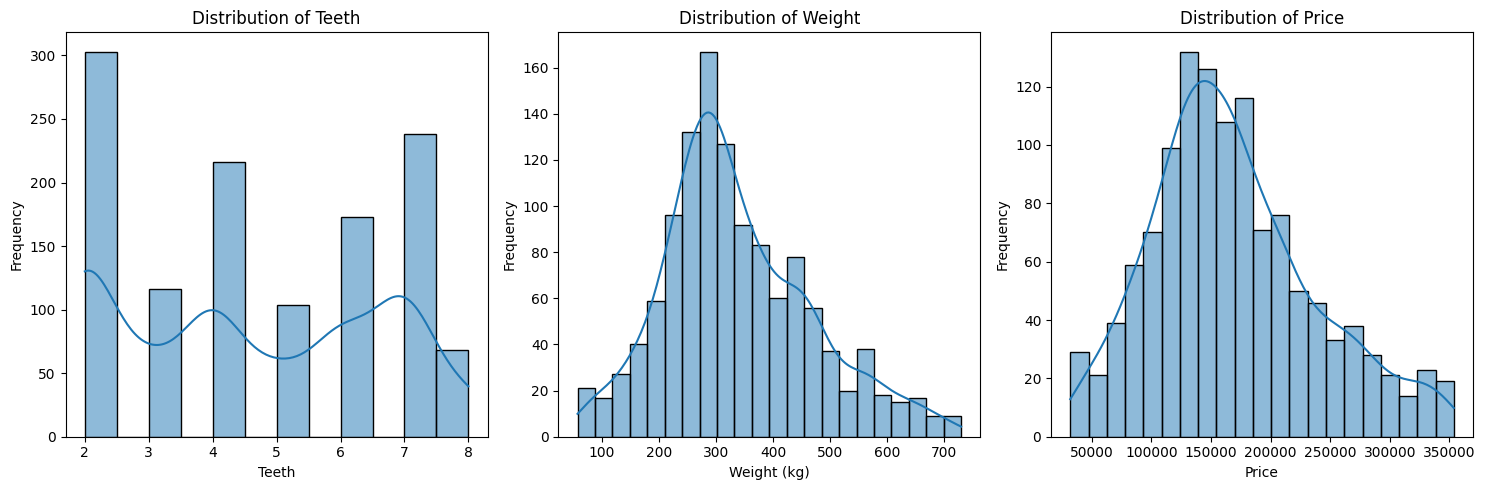

In [ ]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

# Histogram for Teeth
sns.histplot(df['Teeth'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Teeth')
axes[0].set_xlabel('Teeth')
axes[0].set_ylabel('Frequency')

# Histogram for Weight
sns.histplot(df['Weight'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Weight')
axes[1].set_xlabel('Weight (kg)')
axes[1].set_ylabel('Frequency')

# Histogram for Price
sns.histplot(df['Price'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Price')
axes[2].set_xlabel('Price')
axes[2].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

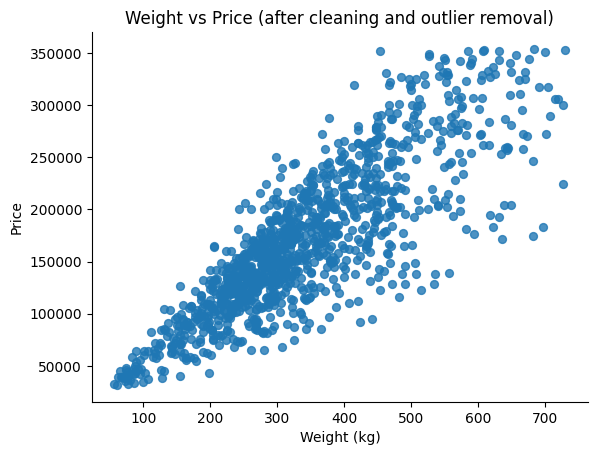

Number of rows: 1218


In [ ]:
# @title Weight vs Price (after cleaning and outlier removal)
df.plot(kind='scatter', x='Weight', y='Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Weight vs Price (after cleaning and outlier removal)')
plt.xlabel('Weight (kg)')
plt.ylabel('Price')
plt.show()
print(f"Number of rows: {len(df)}")

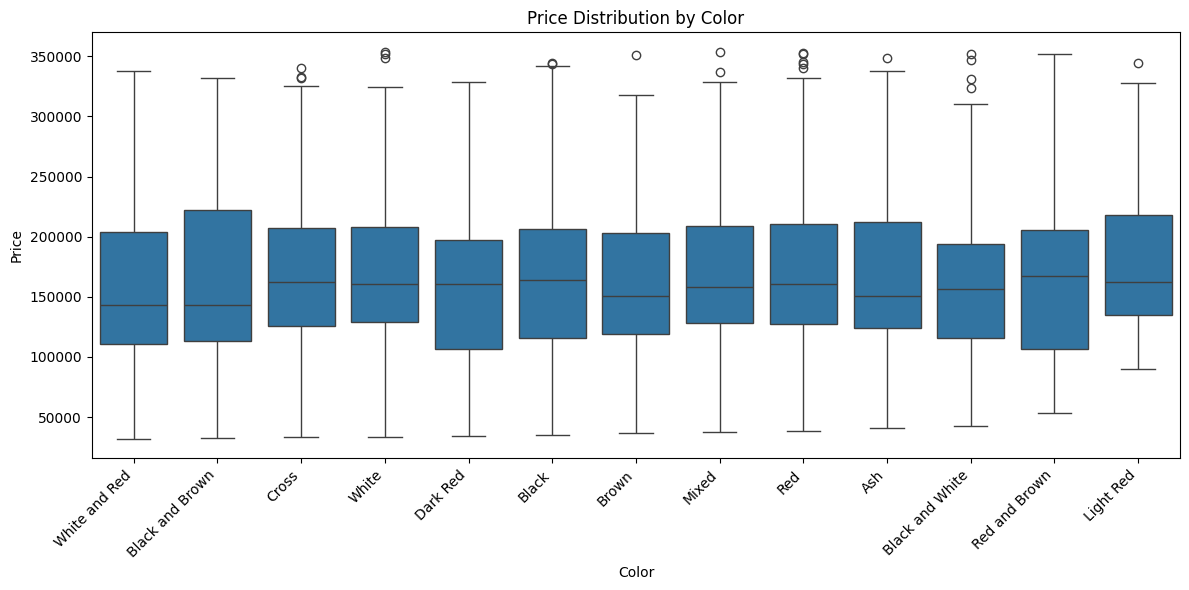

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Color', y='Price', data=df)
plt.title('Price Distribution by Color')
plt.xlabel('Color')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

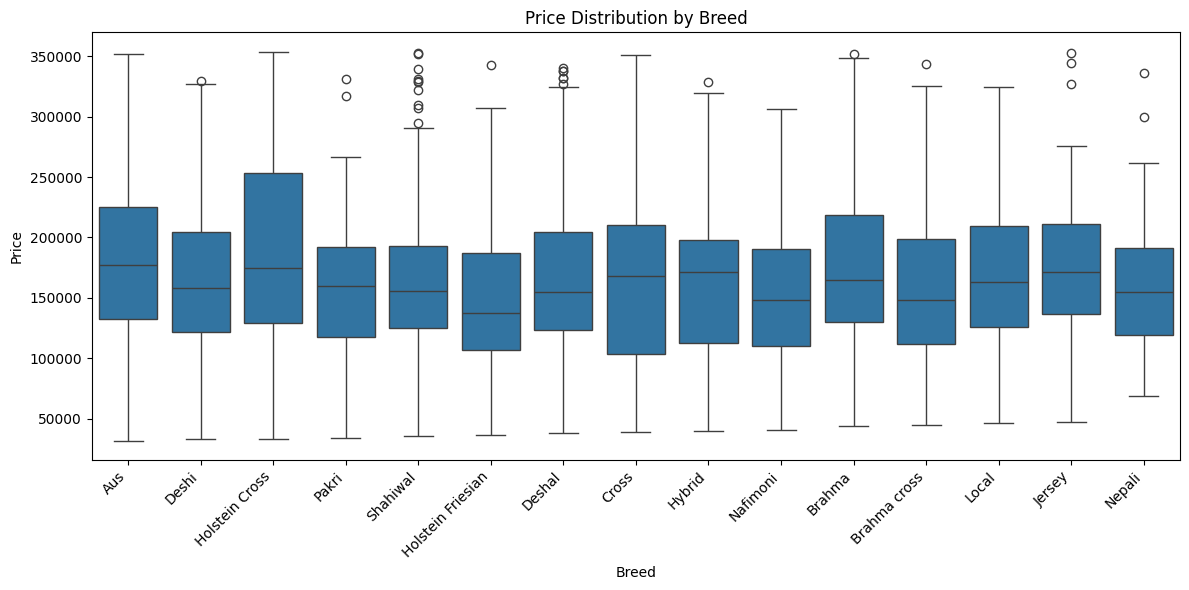

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Breed', y='Price', data=df)
plt.title('Price Distribution by Breed')
plt.xlabel('Breed')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:

# Convert 'Horn' column to 0 or 1
df['Horn'] = df['Horn'].apply(lambda x: 1.0 if x == 'Yes' else 0.0)

# Select categorical columns to encode
categorical_cols = ['Color', 'Gender', 'Breed', 'Location']
df_categorical = df[categorical_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df_categorical)

# Create a DataFrame from the encoded data with appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns from the DataFrame
df_numeric = df.drop(columns=categorical_cols)

# Concatenate the original numerical columns with the encoded categorical columns
df_encoded = pd.concat([df_numeric.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


display(df_encoded.head())

,Age,Teeth,Weight,Horn,Price,Color_Ash,Color_Black,Color_Black and Brown,Color_Black and White,Color_Brown,...,Location_Mymenshing,Location_Naogaon,Location_Narayanganj,Location_Nilfamari,Location_Pabna,Location_Rangpur,Location_Sabujbagh,Location_Sharifganj,Location_Sylhet,Location_Tebunia
0,5,7,60.495033,1.0,31815.05469,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,77.287780,1.0,32670.61943,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,8,56.999058,1.0,33131.58034,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,86.546212,0.0,33789.06166,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,7,99.841093,1.0,34680.27246,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# # Select numerical columns to scale (excluding the encoded categorical columns and the target variable 'Price')
# numerical_cols_to_scale = ['Age', 'Teeth', 'Weight']

# # Initialize StandardScaler
# scaler = StandardScaler()

# # Apply scaling to the selected numerical columns
# df_encoded[numerical_cols_to_scale] = scaler.fit_transform(df_encoded[numerical_cols_to_scale])

# display(df_encoded.head())

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Display correlations with 'Price'
print("Correlation with Price:")
print(correlation_matrix['Price'].sort_values(ascending=False))

Correlation with Price:
Price                      1.000000
Weight                     0.838893
Breed_Holstein Cross       0.103925
Location_Kurigram          0.063780
Location_Sabujbagh         0.061895
Location_Dhaka             0.052450
Color_Light Red            0.039938
Breed_Aus                  0.025120
Breed_Jersey               0.025017
Color_White                0.020518
Location_Narayanganj       0.019557
Breed_Brahma               0.018391
Color_Red                  0.018050
Color_Ash                  0.015687
Breed_Cross                0.013296
Teeth                      0.008887
Location_Nilfamari         0.008242
Gender_Female              0.007942
Breed_Local                0.006924
Location_Kishoreganj       0.006597
Age                        0.004844
Color_Mixed                0.003368
Color_Cross                0.002476
Location_Pabna             0.001379
Location_Sharifganj       -0.000212
Color_Black and Brown     -0.000549
Location_Gazipur          -0.002051
Colo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Separate features (X) and target variable (y)
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Define a filename for your model
filename = 'random_forest_price_model.joblib'

# Save the model to the file
joblib.dump(model, filename)

print(f"Model saved to {filename}")

Mean Absolute Percentage Error (MAPE): 19.60%
Model saved to random_forest_price_model.joblib


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import joblib

# Separate features (X) and target variable (y)
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

# Assuming y_bins was created in a previous cell for stratified splitting
# If not, you might need to create it here or use a simple train_test_split
# Create bins for stratified sampling (if not already created)
y_bins = pd.cut(y, bins=10, labels=False, duplicates='drop')


# Split the data into training and testing sets using stratified sampling on bins
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_bins)


# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


# Define a filename for your model
filename = 'linear_regrassion_model.joblib'

# Save the model to the file
joblib.dump(model, filename)

print(f"Model saved to {filename}")


Mean Absolute Percentage Error (MAPE): 19.03%
Model saved to linear_regrassion_model.joblib


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Initialize and train the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate the model
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr) * 100
print(f"Mean Absolute Percentage Error (MAPE) (Gradient Boosting): {mape_gbr:.2f}%")

# Define a filename for your model
filename = 'gradient_boosting_price_model.joblib'

# Save the model to the file
joblib.dump(gbr_model, filename)

print(f"Model saved to {filename}")

Mean Absolute Percentage Error (MAPE) (Gradient Boosting): 18.41%
Model saved to gradient_boosting_price_model.joblib


In [ ]:
import joblib
from sklearn.metrics import mean_absolute_percentage_error

# Load the saved Random Forest model
loaded_rf_model = joblib.load('/content/random_forest_price_model.joblib')
# Load the saved Gradient Boosting model
loaded_gbr_model = joblib.load('/content/gradient_boosting_price_model.joblib')
# Load the saved Linear Regression model
loaded_lr_model = joblib.load('/content/linear_regrassion_model.joblib')


# Make predictions on the test set using the loaded models
y_pred_rf_test = loaded_rf_model.predict(X_test)
y_pred_gbr_test = loaded_gbr_model.predict(X_test)
y_pred_lr_test = loaded_lr_model.predict(X_test)


# Evaluate the loaded models
mape_rf_test = mean_absolute_percentage_error(y_test, y_pred_rf_test) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Data (Random Forest): {mape_rf_test:.2f}%")

mape_gbr_test = mean_absolute_percentage_error(y_test, y_pred_gbr_test) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Data (Gradient Boosting): {mape_gbr_test:.2f}%")

mape_lr_test = mean_absolute_percentage_error(y_test, y_pred_lr_test) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Test Data (Linear Regression): {mape_lr_test:.2f}%")

Mean Absolute Percentage Error (MAPE) on Test Data (Random Forest): 9.90%
Mean Absolute Percentage Error (MAPE) on Test Data (Gradient Boosting): 18.41%
Mean Absolute Percentage Error (MAPE) on Test Data (Linear Regression): 19.03%


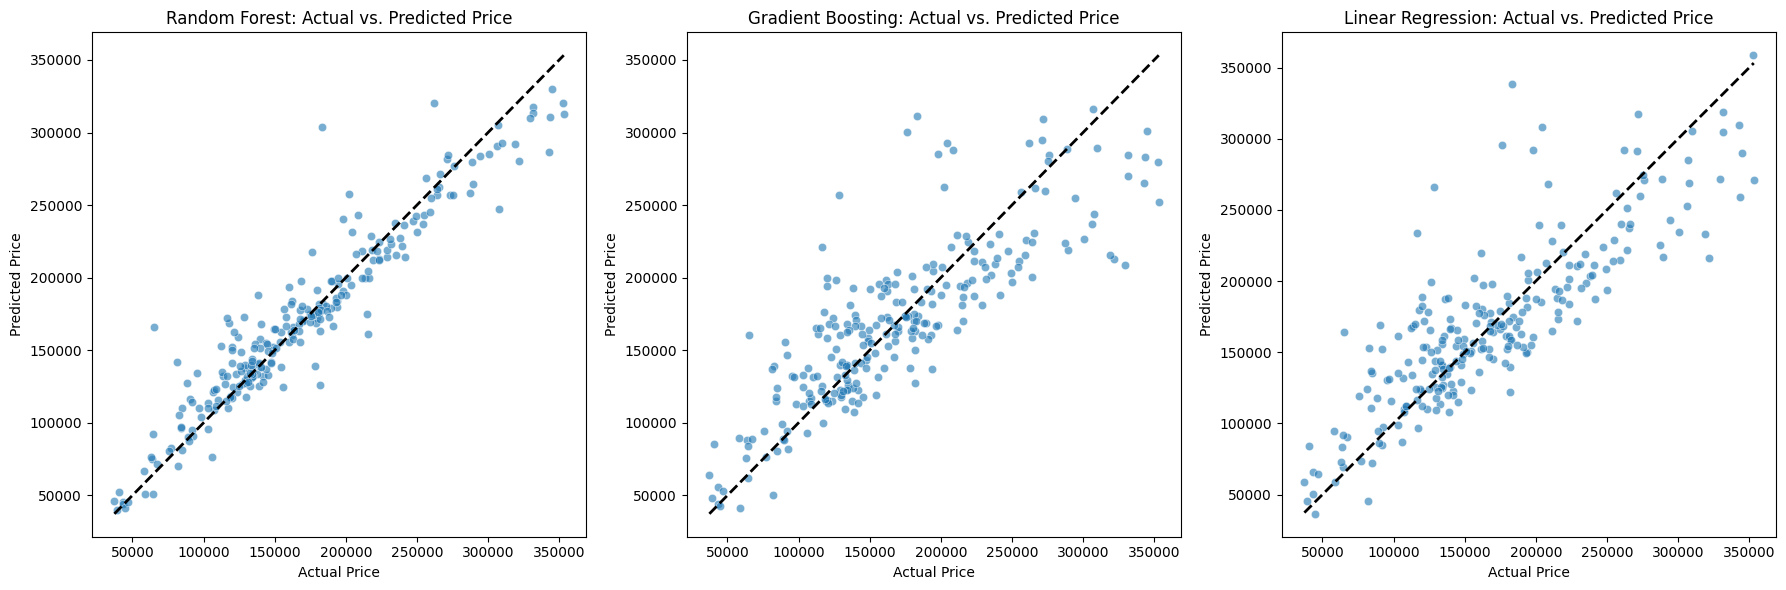

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Random Forest
sns.scatterplot(x=y_test, y=y_test, ax=axes[0], color='blue', label='Actual', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_rf_test, ax=axes[0], color='red', label='Predicted', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line
axes[0].set_title('Random Forest: Actual vs. Predicted Price')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].legend()


# Plot for Gradient Boosting
sns.scatterplot(x=y_test, y=y_test, ax=axes[1], color='blue', label='Actual', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_gbr_test, ax=axes[1], color='red', label='Predicted', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line
axes[1].set_title('Gradient Boosting: Actual vs. Predicted Price')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].legend()


# Plot for Linear Regression
sns.scatterplot(x=y_test, y=y_test, ax=axes[2], color='blue', label='Actual', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lr_test, ax=axes[2], color='red', label='Predicted', alpha=0.6)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line
axes[2].set_title('Linear Regression: Actual vs. Predicted Price')
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')
axes[2].legend()


plt.tight_layout()
plt.show()

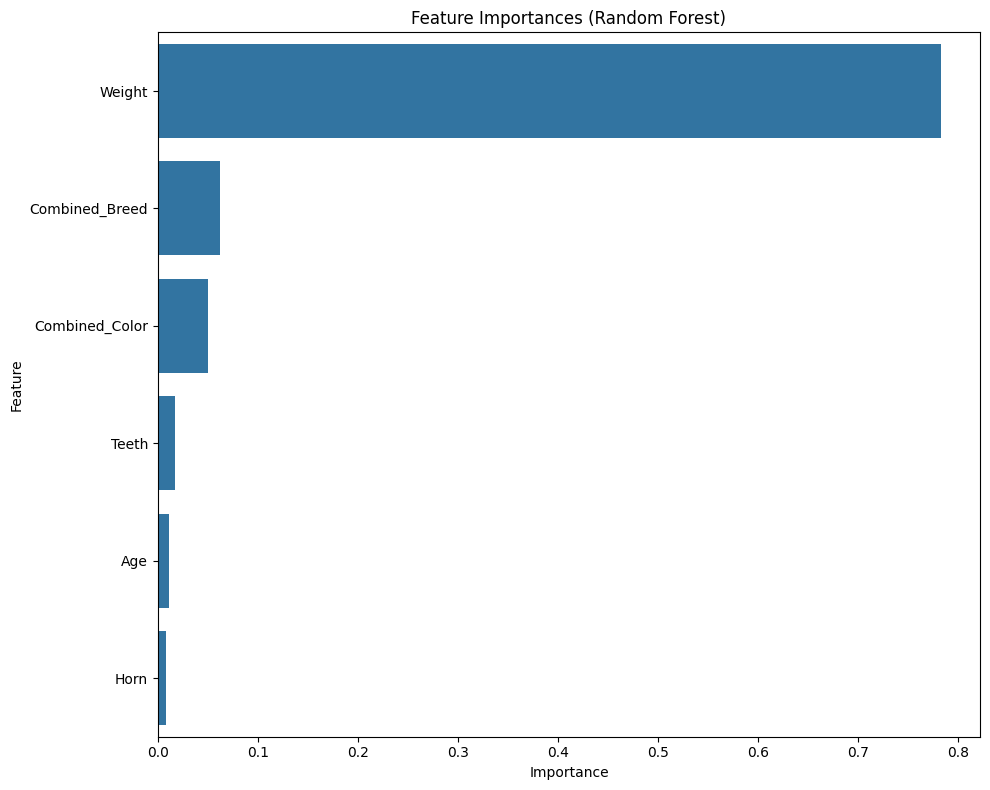

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained Random Forest model
feature_importances = loaded_rf_model.feature_importances_

# Create a pandas Series for easier visualization
feature_importance_series = pd.Series(feature_importances, index=X_train.columns)

# Combine importances for 'Color' features
color_features = [col for col in X_train.columns if 'Color_' in col]
combined_color_importance = feature_importance_series[color_features].sum()

# Combine importances for 'Breed' features
breed_features = [col for col in X_train.columns if 'Breed_' in col]
combined_breed_importance = feature_importance_series[breed_features].sum()

# Select the individual features and add the combined features
selected_features_importance = feature_importance_series[['Weight', 'Horn', 'Age', 'Teeth']]
combined_features_importance = pd.Series({
    'Combined_Color': combined_color_importance,
    'Combined_Breed': combined_breed_importance
})

# Concatenate the selected and combined features and sort
all_selected_importances = pd.concat([selected_features_importance, combined_features_importance]).sort_values(ascending=False)


# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=all_selected_importances.values, y=all_selected_importances.index)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import pandas as pd

# Load the saved models
loaded_rf_model = joblib.load('/content/random_forest_price_model.joblib')
loaded_gbr_model = joblib.load('/content/gradient_boosting_price_model.joblib')
loaded_lr_model = joblib.load('/content/linear_regrassion_model.joblib')


# Create new data for prediction (example)
# This DataFrame must have the same columns as the training data (X_train)
# Replace with your actual new data
new_data = {
    'Age': [2],
    'Teeth': [4],
    'Weight': [350],
    'Horn': [0.0],
    'Color_Ash': [0.0],
    'Color_Black': [0.0],
    'Color_Black and Brown': [0.0],
    'Color_Black and White': [0.0],
    'Color_Brown': [0.0],
    'Color_Cross': [0.0],
    'Color_Dark Red': [0.0],
    'Color_Light Red': [0.0],
    'Color_Mixed': [0.0],
    'Color_Red': [1.0],
    'Color_Red and Brown': [0.0],
    'Color_White': [0.0],
    'Color_White and Red': [0.0],
    'Gender_Female': [0.0],
    'Gender_Male': [1.0],
    'Breed_Aus': [0.0],
    'Breed_Brahma': [0.0],
    'Breed_Brahma cross': [0.0],
    'Breed_Cross': [0.0],
    'Breed_Deshal': [0.0],
    'Breed_Deshi': [0.0],
    'Breed_Holstein Cross': [0.0],
    'Breed_Holstein Friesian': [0.0],
    'Breed_Hybrid': [0.0],
    'Breed_Jersey': [0.0],
    'Breed_Local': [1.0],
    'Breed_Nafimoni': [0.0],
    'Breed_Nepali': [0.0],
    'Breed_Pakri': [0.0],
    'Breed_Shahiwal': [0.0],
    'Location_Bogura': [0.0],
    'Location_Chittagong': [0.0],
    'Location_Dhaka': [1.0],
    'Location_Gazipur': [0.0],
    'Location_Kishoreganj': [0.0],
    'Location_Kurigram': [0.0],
    'Location_Kushtia': [0.0],
    'Location_Mirpur': [0.0],
    'Location_Mymenshing': [0.0],
    'Location_Naogaon': [0.0],
    'Location_Narayanganj': [0.0],
    'Location_Nilfamari': [0.0],
    'Location_Pabna': [0.0],
    'Location_Rangpur': [0.0],
    'Location_Sabujbagh': [0.0],
    'Location_Sharifganj': [0.0],
    'Location_Sylhet': [0.0],
    'Location_Tebunia': [0.0]
}

new_df = pd.DataFrame(new_data)

# Ensure the order of columns in new_df matches the order in X_train
# This is crucial for correct prediction
new_df = new_df[X_train.columns]


# Make predictions on the new data using the loaded models
y_pred_rf_new = loaded_rf_model.predict(new_df)
y_pred_gbr_new = loaded_gbr_model.predict(new_df)
y_pred_lr_new = loaded_lr_model.predict(new_df)


# Print the predictions
print("Model Predictions on New Data:")
print(f"Random Forest: {y_pred_rf_new}")
print(f"Gradient Boosting: {y_pred_gbr_new}")
print(f"Linear Regression: {y_pred_lr_new}")

Model Predictions on New Data:
Random Forest: [202113.604772]
Gradient Boosting: [197938.79362465]
Linear Regression: [203895.54102279]
